<h1>Kobe Bryant Shot Selection</h1>

<h2>Import necessary libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras.constraints import max_norm
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

<h2>Load the data</h2>

In [2]:
all_data = pd.read_csv('data.csv')

requested_prediction = all_data[all_data['shot_made_flag'].isnull()].reset_index(drop = True).drop_duplicates()
data = all_data[all_data['shot_made_flag'].notnull()].reset_index(drop = True).drop_duplicates()
data['game_date'] = pd.to_datetime(data['game_date'])

data

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
1,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
2,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
3,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
4,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30692
25693,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
25694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
25695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


<h2>Check if there are some null values</h2>

In [3]:
pd.isnull(data).sum()

action_type           0
combined_shot_type    0
game_event_id         0
game_id               0
lat                   0
loc_x                 0
loc_y                 0
lon                   0
minutes_remaining     0
period                0
playoffs              0
season                0
seconds_remaining     0
shot_distance         0
shot_made_flag        0
shot_type             0
shot_zone_area        0
shot_zone_basic       0
shot_zone_range       0
team_id               0
team_name             0
game_date             0
matchup               0
opponent              0
shot_id               0
dtype: int64

<h2>What Kobe's favorite type of shot is?</h2>

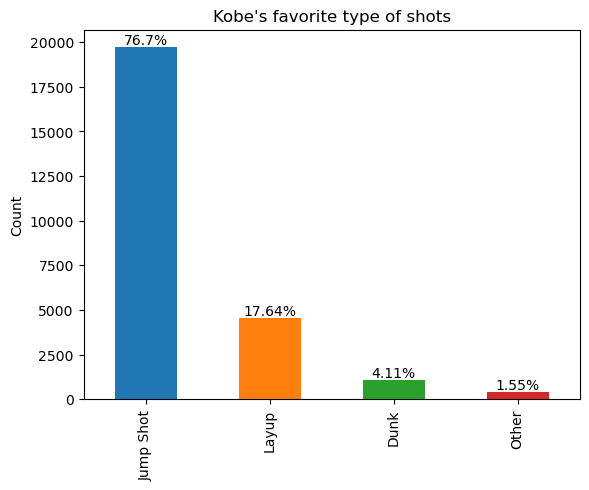

In [4]:
top_3_shots = data['combined_shot_type'].value_counts().head(3)
top_3_shots['Other'] = data['combined_shot_type'].value_counts()[3:].sum()

colors = [(31/255, 119/255, 180/255),
          (255/255, 127/255, 14/255),
          (44/255, 160/255, 44/255),
          (214/255, 39/255, 40/255)]

total_shots = data['combined_shot_type'].count()
percentages = (top_3_shots / total_shots * 100).round(2)

ax = top_3_shots.plot(kind = 'bar', color = colors)

for i, v in enumerate(top_3_shots):
    ax.text(i, v + 5, f'{percentages[i]}%', ha = 'center', va = 'bottom')

plt.title("Kobe's favorite type of shots")
plt.ylabel("Count")
plt.show()

<h2>Check Kobe's shooting percentage for his favorite shots</h2>

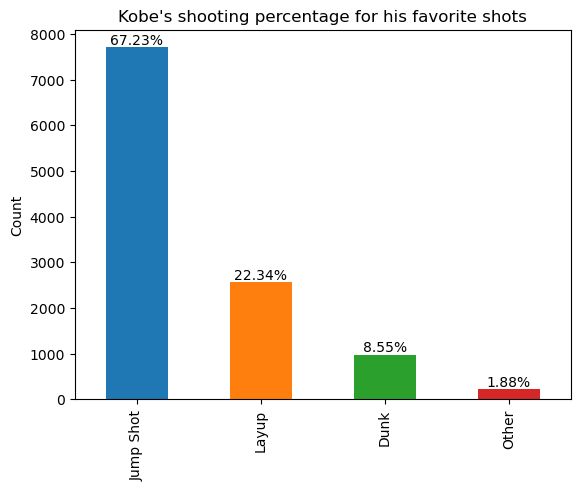

In [5]:
top_3_shots_made = data['combined_shot_type'][data['shot_made_flag'] == 1].value_counts().head(3)
top_3_shots_made['Other'] = data['combined_shot_type'][data['shot_made_flag'] == 1].value_counts()[3:].sum()

total_shots_made = data['combined_shot_type'][data['shot_made_flag'] == 1].count()
percentages_made = (top_3_shots_made / total_shots_made * 100).round(2)

ax = top_3_shots_made.plot(kind = 'bar', color = colors)

for i, v in enumerate(top_3_shots_made):
    ax.text(i, v + 5, f'{percentages_made[i]}%', ha = 'center', va = 'bottom')

plt.title("Kobe's shooting percentage for his favorite shots")
plt.ylabel("Count")
plt.show()

<h2>Shot attempts as a function of time (considering a 12min long periods and 5min overtime)</h2>

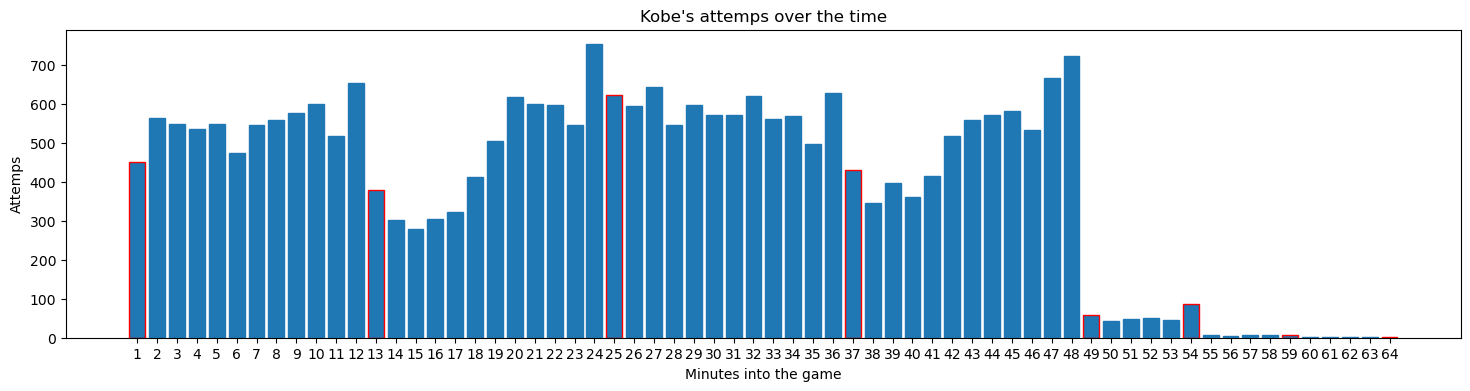

In [6]:
data['current_minute_playing'] = np.where(data['period'] > 4, (4 * 12 + (data['period'] - 5) * 5), ((data['period'] - 1) * 12)) + (12 - data['minutes_remaining']) + np.where(data['seconds_remaining'] == 0, 1, 0)

x = np.arange(1, len(data['current_minute_playing'].value_counts().sort_index()) + 1)

edge_colors = ['red' if i in [1, 13, 25, 37, 49, 54, 59, 64] else '#1f77b4' for i in x]

plt.figure(figsize = (18, 4))

plt.bar(x, data['current_minute_playing'].value_counts().sort_index().tolist(), edgecolor = edge_colors)
plt.xticks(x)
plt.title("Kobe's attemps over the time")
plt.xlabel("Minutes into the game")
plt.ylabel("Attemps")
plt.show()

<h5>It seems like Kobe is taking crucial shots at the end of every period.</h5>
<h5>At the beginning of the 2nd and 4th period, he's usually out of the game, considering the number of attempts in that time.</h5>

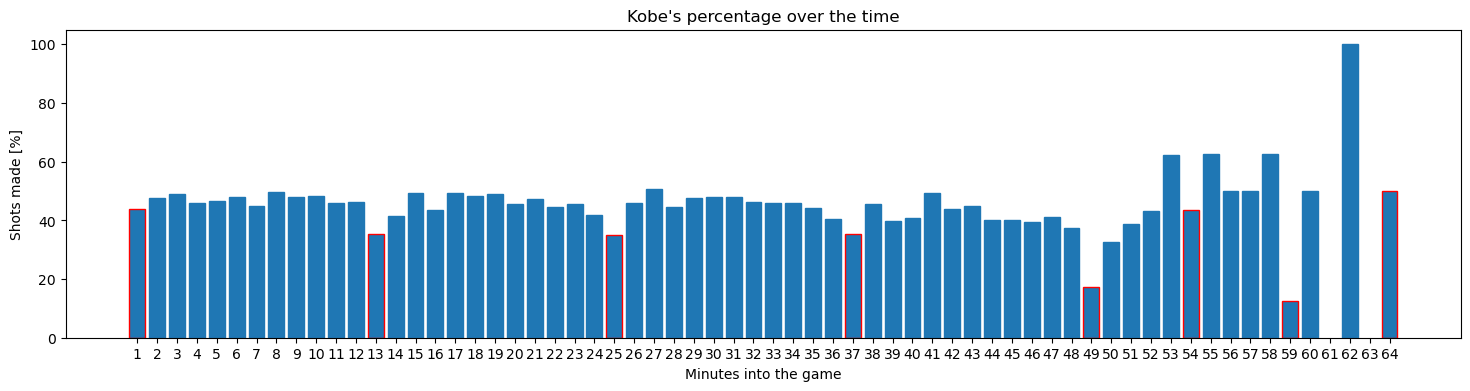

In [7]:
x = np.arange(1, len(((data['current_minute_playing'][data['shot_made_flag'] == 1].value_counts().sort_index() / data['current_minute_playing'].value_counts().sort_index()) * 100).tolist()) + 1)

plt.figure(figsize = (18, 4))

plt.bar(x, ((data['current_minute_playing'][data['shot_made_flag'] == 1].value_counts().sort_index() / data['current_minute_playing'].value_counts().sort_index()) * 100).tolist(), edgecolor = edge_colors)
plt.xticks(x)
plt.title("Kobe's percentage over the time")
plt.xlabel("Minutes into the game")
plt.ylabel("Shots made [%]")
plt.show()

<h5>Kobe's shooting percentage is at its lowest at the start of each period. This could be due to breaks between periods. As each period progresses, the percentage gradually increases as the period advances but declines as the period's end approaches, reaching its lowest point in the last minute. For the overtime periods, we can't rely on the percentages because there aren't many shots taken, as there are fewer games that go into overtime.</h5>

<h2>Spatial location aspect of Kobe's shots</h2>

The function draw_court() is stolen from [MichaelKrueger's](https://www.kaggle.com/bbx396) [script](https://www.kaggle.com/code/bbx396/kobechart/notebook)

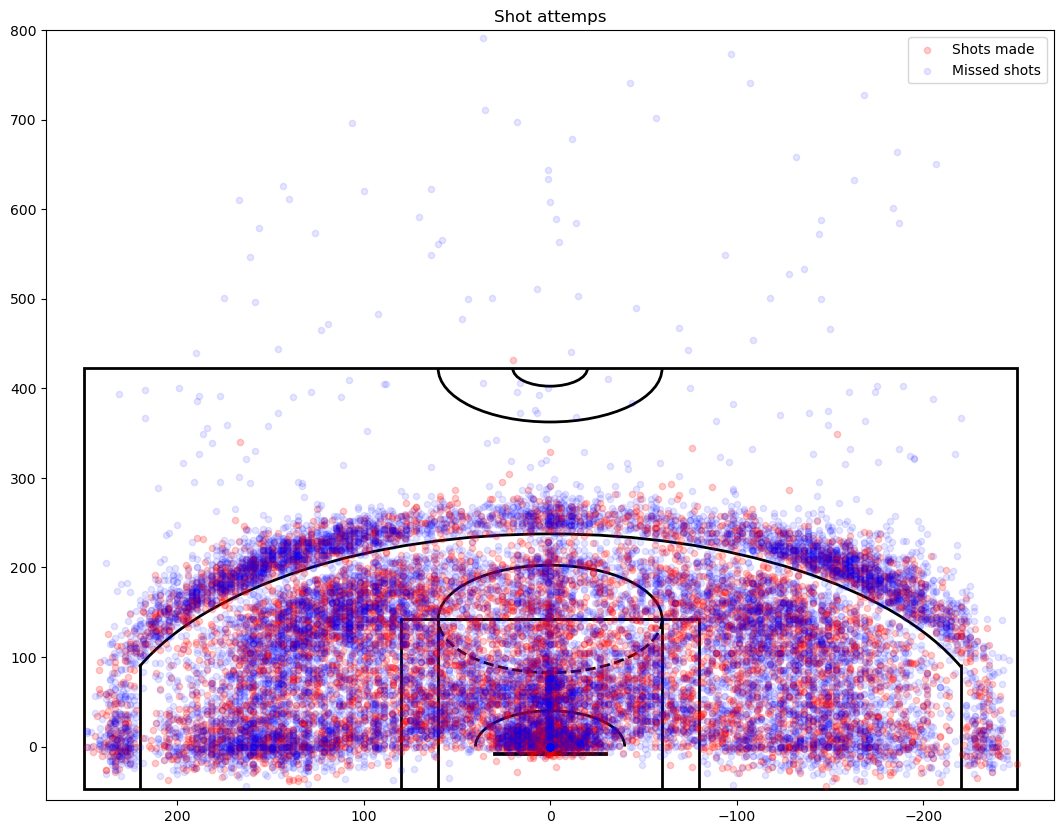

In [8]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize = (13, 10))

draw_court(outer_lines = True)
plt.ylim(-60, 800)
plt.xlim(270, -270)
plt.title('Shot attemps')

plt.scatter(data[data['shot_made_flag'] == 1]['loc_x'], data[data['shot_made_flag'] == 1]['loc_y'], s = 20, alpha = 0.2, c = 'red', label = 'Shots made')
plt.scatter(data[data['shot_made_flag'] == 0]['loc_x'], data[data['shot_made_flag'] == 0]['loc_y'], s = 20, alpha = 0.1, c = 'blue', label = 'Missed shots')

plt.legend()
plt.show()

<h5>We can see that Kobe tends to take more shots on his left side, possibly because he is right-handed. Most of his shots for three points and from half-distance are on the right side of the court. Additionally, there are numerous attempts from under the basket and very close to the basket. The distribution on the left side of the court is somewhat similar, though with fewer attempts. What's interesting is that Kobe only made one field goal from his half of the court.</h5>

<h2>Let's see the percentages of shots in different shot zone areas</h2>

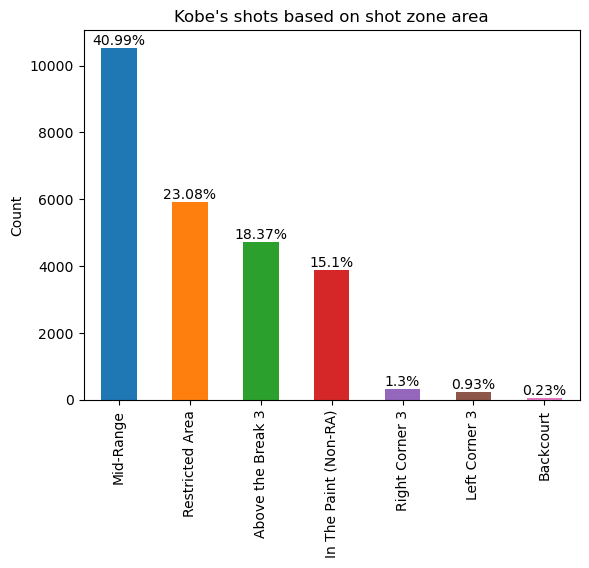

In [9]:
shots_from_various_zones = data['shot_zone_basic'].value_counts()

percentages_from_various_zones = (shots_from_various_zones / total_shots * 100).round(2)

colors = [(31/255, 119/255, 180/255),
          (255/255, 127/255, 14/255),
          (44/255, 160/255, 44/255),
          (214/255, 39/255, 40/255),
          (148/255, 103/255, 189/255),
          (140/255, 86/255, 75/255),
          (227/255, 119/255, 194/255)]

ax = shots_from_various_zones.plot(kind = 'bar', color = colors)

for i, v in enumerate(shots_from_various_zones):
    ax.text(i, v + 5, f'{percentages_from_various_zones[i]}%', ha = 'center', va = 'bottom')

plt.title("Kobe's shots based on shot zone area")
plt.ylabel("Count")
plt.show()

<h2>Let's see the percentages of shots made in different shot zone areas</h2>

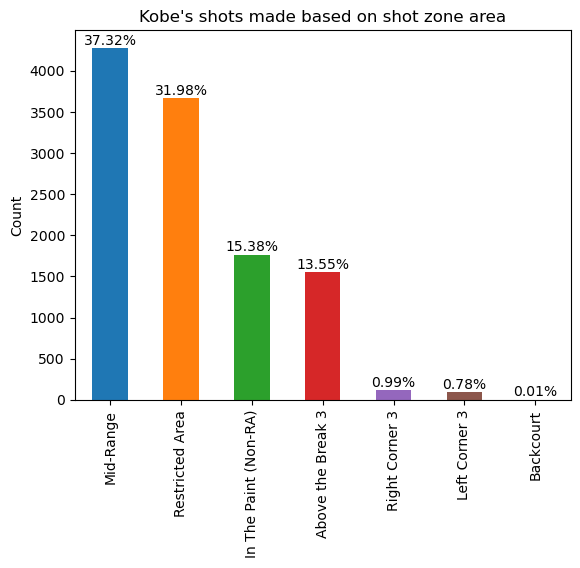

In [10]:
shots_made_from_various_zones = data['shot_zone_basic'][data['shot_made_flag'] == 1].value_counts()

percentages_from_various_zones_made = (shots_made_from_various_zones / total_shots_made * 100).round(2)

ax = shots_made_from_various_zones.plot(kind = 'bar', color = colors)

for i, v in enumerate(shots_made_from_various_zones):
    ax.text(i, v + 5, f'{percentages_from_various_zones_made[i]}%', ha = 'center', va = 'bottom')

plt.title("Kobe's shots made based on shot zone area")
plt.ylabel("Count")
plt.show()

<h2>Coding categorical data into numerical representation</h2>

In [11]:
data['year'] = data['game_date'].dt.year
data['month'] = data['game_date'].dt.month
data['day'] = data['game_date'].dt.day

data.drop('game_date', axis = 1, inplace = True)

categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
categorical_int_cols = ['game_event_id', 'game_id', 'team_id']

label_encoders_categorical = {col: LabelEncoder() for col in categorical_cols}
label_encoders_int_categorical = {col: LabelEncoder() for col in categorical_int_cols}

for col in categorical_cols:
    data[col] = label_encoders_categorical[col].fit_transform(data[col])

for col in categorical_int_cols:
    data[col] = label_encoders_int_categorical[col].fit_transform(data[col])    

data

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_zone_range,team_id,team_name,matchup,opponent,shot_id,current_minute_playing,year,month,day
0,25,3,10,0,34.0443,-157,0,-118.4268,10,1,...,2,0,0,28,25,2,2,2000,10,31
1,25,3,33,0,33.9093,-101,135,-118.3708,7,1,...,0,0,0,28,25,3,5,2000,10,31
2,25,3,41,0,33.8693,138,175,-118.1318,6,1,...,0,0,0,28,25,4,6,2000,10,31
3,4,1,153,0,34.0443,0,0,-118.2698,6,2,...,4,0,0,28,25,5,18,2000,10,31
4,25,3,242,0,34.0553,-145,-11,-118.4148,9,3,...,2,0,0,28,25,6,27,2000,10,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,11,4,380,1557,34.0443,0,0,-118.2698,7,4,...,4,0,0,49,11,30692,41,2000,6,19
25693,25,3,395,1557,33.9963,1,48,-118.2688,6,4,...,4,0,0,49,11,30693,42,2000,6,19
25694,40,3,424,1557,33.8783,-134,166,-118.4038,3,4,...,0,0,0,49,11,30695,45,2000,6,19
25695,25,3,446,1557,33.7773,31,267,-118.2388,2,4,...,1,0,0,49,11,30696,46,2000,6,19


<h2>Correlation matrix</h2>

<AxesSubplot:>

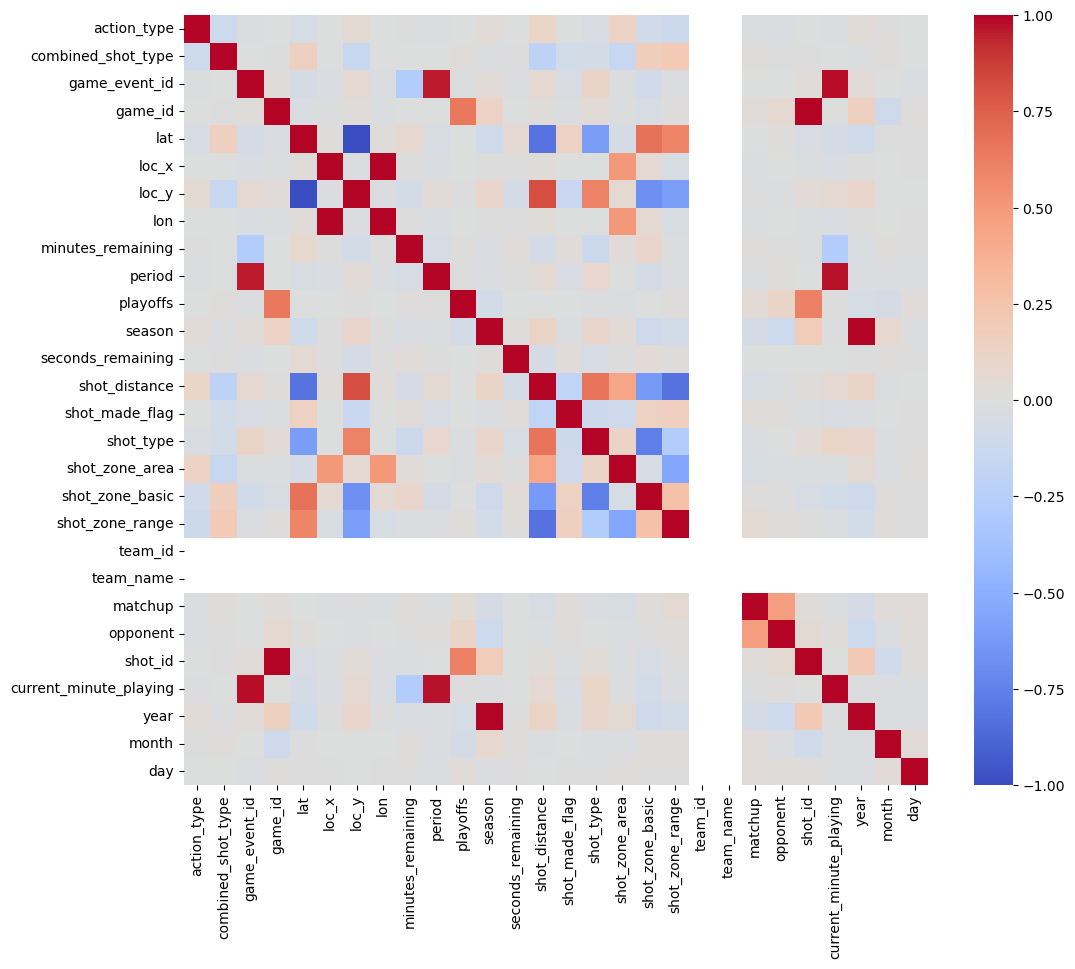

In [12]:
correlations = data.corr()

plt.figure(figsize = (12, 10))

sns.heatmap(correlations, cmap = "coolwarm", annot = False)

<h2>Pearson correlation coefficients (PCC)</h2>

abs(PCC):
action_type               0.003766
combined_shot_type        0.079347
game_event_id             0.037225
game_id                   0.011860
lat                       0.148070
loc_x                     0.000848
loc_y                     0.148070
lon                       0.000848
minutes_remaining         0.028342
period                    0.032152
playoffs                  0.001257
season                    0.018777
seconds_remaining         0.030804
shot_distance             0.198242
shot_type                 0.121462
shot_zone_area            0.102592
shot_zone_basic           0.139015
shot_zone_range           0.157635
team_id                        NaN
team_name                      NaN
matchup                   0.021960
opponent                  0.008408
shot_id                   0.013016
current_minute_playing    0.038320
year                      0.018642
month                     0.004293
day                       0.001345
dtype: float64


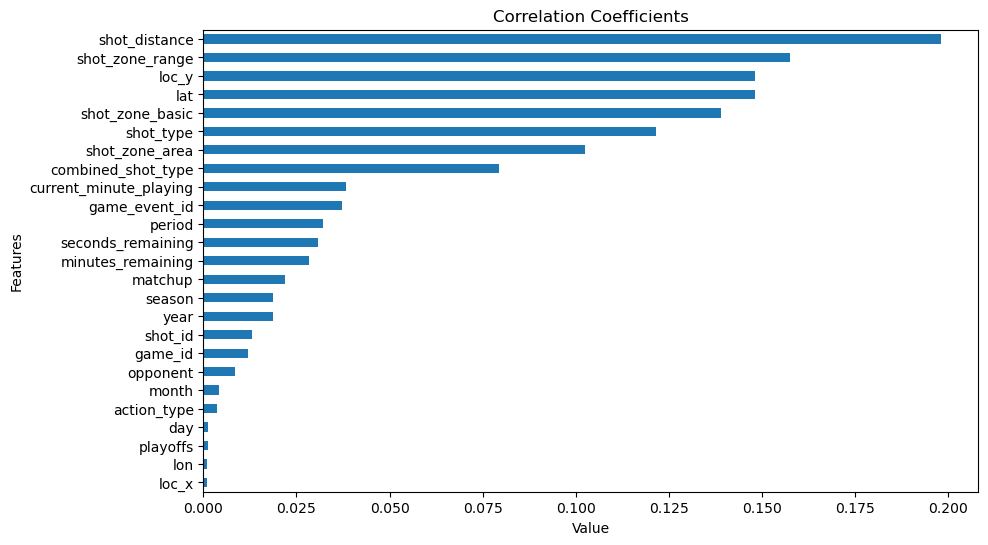

In [13]:
correlation_series = pd.Series(dtype = 'float64')

for i in range(0, data.shape[1]):
    if (data.columns[i] != 'shot_made_flag'):
        x = data[data.columns[i]]
        y = data['shot_made_flag']

        if (np.std(x) != 0 and np.std(y) != 0):
            correlation_series[data.columns[i]] = abs(np.corrcoef(x, y)[0][1])
        else:
            correlation_series[data.columns[i]] = np.nan

print("abs(PCC):")
print(correlation_series)

correlation_series = correlation_series.sort_values().dropna()

correlation_series.plot(kind = 'barh', figsize = (10, 6), title = 'Correlation Coefficients')
plt.xlabel('Value')
plt.ylabel('Features')
plt.show()

<h2>Are classes unbalanced?</h2>

Percentage of shots made: 44.62 %
Percentage of shots not made: 55.38 %
Classes are well balanced!


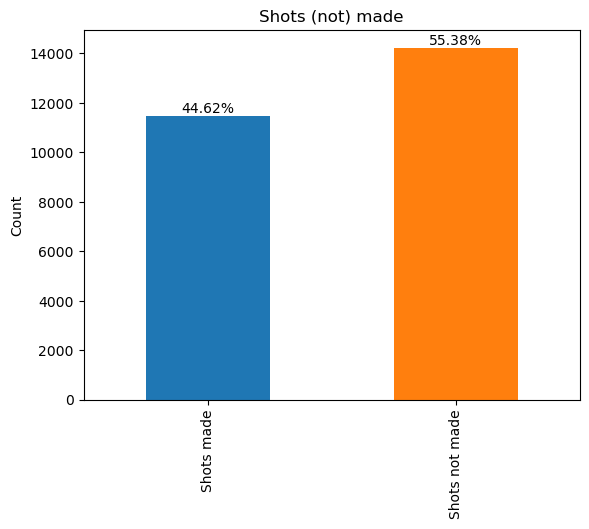

In [14]:
shots_made = data['shot_made_flag'][data['shot_made_flag'] == 1].count()
shots_not_made = data['shot_made_flag'][data['shot_made_flag'] == 0].count()

shots_series = pd.Series([shots_made, shots_not_made], index=['Shots made', 'Shots not made'])

percentages_shots_made = (shots_made / (shots_made + shots_not_made) * 100).round(2)
percentages_shots_not_made = 100 - percentages_shots_made

percentages_series = pd.Series([percentages_shots_made, percentages_shots_not_made], index = ['Percentage Shots made', 'Percentage Shots not made'])

print("Percentage of shots made:", percentages_shots_made, "%")
print("Percentage of shots not made:", percentages_shots_not_made, "%")

if (40 < percentages_shots_made < 60):
    print("Classes are well balanced!")
else:
    print("Classes are not well balanced!")

colors = [(31/255, 119/255, 180/255),
          (255/255, 127/255, 14/255)]

ax = shots_series.plot(kind = 'bar', color = colors)

for i, v in enumerate(shots_series):
    ax.text(i, v + 5, f'{percentages_series[i]}%', ha = 'center', va = 'bottom')

plt.ylabel('Count')
plt.title('Shots (not) made')
plt.show()

<h2>Lets train different ML models and compare them (RF, GB, NN)</h2>

<h2>Random Forest (RF) Classifier</h2>

In [15]:
input_data = data.drop(columns = 'shot_made_flag')
output_data = data['shot_made_flag']

In [16]:
"""
param_grid = {
    'n_estimators': [20, 30, 50],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

clf = RandomForestClassifier(random_state = 42)

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 10, scoring = 'accuracy')
grid_search.fit(input_data, output_data)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", '%.2f'%(best_score))

best_n_estimators = best_params['n_estimators']
best_criterion = best_params['criterion']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

#####################################################

num_of_execution = 10

sum_acc_RF_train_test = 0
f1_score_RF_train_test = 0

sum_acc_RF_cross_val = 0
f1_score_RF_cross_val = 0

for i in range(0, num_of_execution):
    X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(input_data, output_data, test_size = 0.2, random_state = 42) # 80% training and 20% test
    
    clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, max_depth=best_max_depth, min_samples_split=best_min_samples_split,
                                 min_samples_leaf=best_min_samples_leaf, min_weight_fraction_leaf=0, max_features='sqrt',
                                 max_leaf_nodes=None, min_impurity_decrease=0, bootstrap=True, oob_score=False,
                                 n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None,
                                 ccp_alpha=0, max_samples=None)
    clf.fit(X_train_RF, y_train_RF)
    prediction = clf.predict(X_test_RF)
    
    sum_acc_RF_train_test = sum_acc_RF_train_test + accuracy_score(y_test_RF, prediction)
    f1_score_RF_train_test = f1_score_RF_train_test + f1_score(y_test_RF, prediction)
    
    scores = cross_val_score(clf, input_data, output_data, cv = 10, scoring = 'accuracy')
    sum_acc_RF_cross_val += np.mean(scores)
    
    f1_scores = cross_val_score(clf, input_data, output_data, cv = 10, scoring = 'f1')
    f1_score_RF_cross_val += np.mean(f1_scores)

score_RF_train_test = sum_acc_RF_train_test / num_of_execution * 100
score_f1_RF_train_test = f1_score_RF_train_test / num_of_execution * 100

score_RF_cross_val = sum_acc_RF_cross_val / num_of_execution * 100
score_f1_RF_cross_val = f1_score_RF_cross_val / num_of_execution * 100

print("Mean Accuracy score over 10 executions for Random Forest method using train_test_split:", '%.2f'%(score_RF_train_test), "%")
print("Mean F1 score over 10 executions for Random Forest method using train_test_split:", '%.2f'%(score_f1_RF_train_test), "%")

print("Mean Accuracy score over 10 executions for Random Forest method using cross_val:", '%.2f'%(score_RF_cross_val), "%")
print("Mean F1 score over 10 executions for Random Forest method using cross_val:", '%.2f'%(score_f1_RF_cross_val), "%")
"""

'\nparam_grid = {\n    \'n_estimators\': [20, 30, 50],\n    \'criterion\': [\'gini\', \'log_loss\'],\n    \'max_depth\': [5, 10],\n    \'min_samples_split\': [2, 3, 4],\n    \'min_samples_leaf\': [1, 2, 3]\n}\n\nclf = RandomForestClassifier(random_state = 42)\n\ngrid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 10, scoring = \'accuracy\')\ngrid_search.fit(input_data, output_data)\n\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\n\nprint("Best Parameters:", best_params)\nprint("Best Accuracy Score:", \'%.2f\'%(best_score))\n\nbest_n_estimators = best_params[\'n_estimators\']\nbest_criterion = best_params[\'criterion\']\nbest_max_depth = best_params[\'max_depth\']\nbest_min_samples_split = best_params[\'min_samples_split\']\nbest_min_samples_leaf = best_params[\'min_samples_leaf\']\n\n#####################################################\n\nnum_of_execution = 10\n\nsum_acc_RF_train_test = 0\nf1_score_RF_train_test = 0\n\nsum_acc_RF_c

<h2>Gradient Boosting (GB) Classifier</h2>

In [17]:
"""
param_grid = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.1, 0.5, 1],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

clf = GradientBoostingClassifier(random_state = 42)

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 10, scoring = 'accuracy')
grid_search.fit(input_data, output_data)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", '%.2f'%(best_score))

best_loss = best_params['loss']
best_learning_rate = best_params['learning_rate']
best_n_estimators = best_params['n_estimators']
best_subsample = best_params['subsample']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

#####################################################

sum_acc_GB_train_test = 0
f1_score_GB_train_test = 0

num_of_execution = 1

for i in range(0, num_of_execution):
    X_train_GB, X_test_GB, y_train_GB, y_test_GB = train_test_split(input_data, output_data, test_size = 0.2, random_state = 42) # 80% training and 20% test
    
    clf = GradientBoostingClassifier(loss=best_loss, learning_rate=best_learning_rate, n_estimators=best_n_estimators, subsample=best_subsample,
                                     criterion='friedman_mse', min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                                     min_weight_fraction_leaf=0, max_depth=3, min_impurity_decrease=0,
                                     init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,
                                     warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0)
    clf.fit(X_train_GB, y_train_GB)
    prediction = clf.predict(X_test_GB)
    
    sum_acc_GB_train_test = sum_acc_GB_train_test + clf.score(X_test_GB, y_test_GB)
    f1_score_GB_train_test = f1_score_GB_train_test + f1_score(y_test_GB, prediction)

score_GB = sum_acc_GB_train_test / num_of_execution * 100
score_f1_GB = f1_score_GB_train_test / num_of_execution * 100

print("Mean Accuracy score over 10 executions for Gradient Boosting method using train_test_split:", '%.2f'%(score_GB), "%")
print("Mean F1 score over 10 executions for Gradient Boosting method using train_test_split:", '%.2f'%(score_f1_GB), "%")
"""
"""
sum_acc_GB = 0
f1_score_GB = 0

for i in range(0, num_of_execution):
    clf = GradientBoostingClassifier(loss=best_loss, learning_rate=best_learning_rate, n_estimators=best_n_estimators, subsample=best_subsample,
                                     criterion='friedman_mse', min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                                     min_weight_fraction_leaf=0, max_depth=3, min_impurity_decrease=0,
                                     init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,
                                     warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0)
    
    scores = cross_val_score(clf, input_data, output_data, cv = 10, scoring = 'accuracy')
    sum_acc_GB += np.mean(scores)
    
    f1_scores = cross_val_score(clf, input_data, output_data, cv = 10, scoring = 'f1')
    f1_score_GB += np.mean(f1_scores)

score_GB = sum_acc_GB / num_of_execution * 100
score_f1_GB = f1_score_GB / num_of_execution * 100

print("Mean Accuracy score over 10 executions for Gradient Boosting method:", score_GB, "%")
print("Mean F1 score over 10 executions for Gradient Boosting method:", score_f1_GB, "%")
"""

'\nsum_acc_GB = 0\nf1_score_GB = 0\n\nfor i in range(0, num_of_execution):\n    clf = GradientBoostingClassifier(loss=best_loss, learning_rate=best_learning_rate, n_estimators=best_n_estimators, subsample=best_subsample,\n                                     criterion=\'friedman_mse\', min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,\n                                     min_weight_fraction_leaf=0, max_depth=3, min_impurity_decrease=0,\n                                     init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,\n                                     warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0)\n    \n    scores = cross_val_score(clf, input_data, output_data, cv = 10, scoring = \'accuracy\')\n    sum_acc_GB += np.mean(scores)\n    \n    f1_scores = cross_val_score(clf, input_data, output_data, cv = 10, scoring = \'f1\')\n    f1_score_GB += np.mean(f1_scores)\n\nscore_G

<h1>Neural Network (NN) Classifier</h1>

In [18]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(input_data, output_data, test_size = 0.2, random_state = 42)

model = Sequential([ 
    Dense(256, activation = 'relu'),  # Input layer with 128 neurons and ReLU activation
    Dropout(0.5),  # Add dropout with a rate of 0.5
    Dense(128, activation = 'relu'),  # Hidden layer with 64 neurons and ReLU activation
    Dropout(0.5),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid') # Output layer with 1 neuron for binary classification using sigmoid activation
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps = 100000, decay_rate = 0.96, staircase = True)

model.compile(optimizer = Adam(learning_rate = lr_schedule), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

model.fit(X_train_NN, y_train_NN, epochs = 50, batch_size = 32, validation_split = 0.1, callbacks = [early_stopping])

test_loss, test_accuracy = model.evaluate(X_test_NN, y_test_NN)
print("Test accuracy:", f'{round(test_accuracy * 100, 2)}%')

Epoch 1/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5061 - loss: 172.6737 - val_accuracy: 0.5516 - val_loss: 0.6895
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5505 - loss: 1.6628 - val_accuracy: 0.5516 - val_loss: 0.6884
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5474 - loss: 0.9003 - val_accuracy: 0.5516 - val_loss: 0.6882
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5541 - loss: 0.8080 - val_accuracy: 0.5516 - val_loss: 0.6882
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5564 - loss: 0.7294 - val_accuracy: 0.5516 - val_loss: 0.6882
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5466 - loss: 0.7115 - val_accuracy: 0.5516 - val_loss: 0.6883
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5503 - loss: 0.7096 - val_accuracy: 0.5516 - val_loss: 0.6882
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5524 - loss: 0.7143 - val_accuracy: 